# Maritime Anomaly Detection Project

## Project Proposal

The Maritime Anomaly Detection Project aims to identify unusual vessel behavior using **Automatic Identification System (AIS)** data. The primary goal is to detect anomalies in a ship’s movement over time, which may indicate potential risks such as collisions, illegal anchoring, or unusual stop patterns.

For this project, I used AIS data from **MarineTraffic** covering a **3-year period (2020–2022)** for a single vessel (*MSC AQUARIUS*). The dataset includes ship positions, speed, heading, and other navigational details.

I explored both **rule-based anomaly flags** (e.g., off-land stops, suspicious anchorage, missing data) and **machine learning models** such as DBSCAN clustering and an LSTM autoencoder for trajectory-based anomaly detection. While the clustering-based methods successfully flagged distinct behaviors, the LSTM model tended to over-flag anomalies, marking continuous periods (e.g., daily anomalies for a month) for some ships.

---

## Topic Description

AIS data is widely used in maritime navigation and monitoring, but detecting anomalies in vessel behavior is challenging due to noisy signals, missing values, and natural variability in ship movements. This project seeks to apply both clustering and deep learning approaches to highlight suspicious patterns in vessel trajectories and port activities, with the ultimate goal of improving maritime safety and risk assessment.

---

## Dataset & Features

AIS dataset retrieved from **MarineTraffic**, containing the following variables:

| Variable         | Description                                    |
| ---------------- | ---------------------------------------------- |
| mmsi             | Maritime Mobile Service Identity (ship ID)     |
| basedatetime     | Timestamp of AIS message                       |
| lat              | Latitude                                       |
| lon              | Longitude                                      |
| sog              | Speed over ground (knots)                      |
| cog              | Course over ground (degrees)                   |
| heading          | Vessel heading (degrees, 511 = unavailable)    |
| vesselname       | Vessel name                                    |
| imo              | International Maritime Organization number     |
| callsign         | Radio callsign                                 |
| vesseltype       | Type of vessel                                 |
| status           | Navigational status (e.g., underway, anchored) |
| length           | Vessel length (m)                              |
| width            | Vessel width (m)                               |
| draft            | Current draft (m)                              |
| cargo            | Cargo type                                     |
| transceiverclass | AIS transceiver class                          |

---

## Anomaly Detection Flags

Several rule-based anomaly categories were defined:

* **Flag 1: Off-land Stops** – Detects clusters of stationary AIS positions far from land.
* **Flag 2: Off-port Stops** – Identifies suspicious stops outside recognized port boundaries.
* **Flag 3: Missing Data** – Flags large time gaps in AIS reporting (e.g., >10 days = Investigate, >25 days = Suspicious).
* **Flag 4: Overstay Duration** – Detects unusually long stays in the same anchorage/port cluster.
* **Flag 5: LSTM Autoencoder** – Sequence reconstruction error used to identify unusual trajectories.

---

## Models

### Unsupervised

* **DBSCAN Clustering**: Applied on vessel coordinates (lat/lon) to detect ports, anchorages, and suspicious stop clusters.
* **Rule-based Flags**: Defined thresholds for missing data, anchorage duration, and geographic context (land vs. sea).

### Deep Learning

* **LSTM Autoencoder**:

  * Input: Sequences of vessel features (lat, lon, speed, heading, course/speed/heading changes, distance from coast).
  * Training: 80% sequences used for training, model reconstructs expected trajectories.
  * Output: High reconstruction error = anomaly.
  * Limitation: Model tends to “over-flag” anomalies, labeling extended continuous periods as anomalous.

---

## Results

* **DBSCAN & Rule-based flags** produced interpretable anomalies such as suspicious offshore stops and long-duration anchorages.
* **LSTM model** detected deviations in trajectories but lacked precision, often marking entire time periods as anomalous.
* Key insight: Rule-based + clustering approaches provided **explainable anomalies**, while LSTM offered potential for trajectory anomaly detection but required further tuning.

---

## Future Work

* Improve LSTM model by tuning thresholds or using hybrid approaches (Isolation Forest + LSTM).
* Extend to multiple ships for comparison and generalization.
* Incorporate external features (e.g., weather, port traffic, restricted zones) for context-aware anomaly detection.
* Develop a real-time anomaly detection dashboard.

---


## Limitations & Reflections

* **Model Accuracy** – Clustering and trajectory-based models did not achieve high accuracy due to AIS data complexity and difficulty defining “normal” vs. “anomalous.”  
* **Collision Case Study** – Detecting a known vessel collision required manual data manipulation, showing challenges in surfacing rare incidents from raw data.  
* **Data Quality** – AIS data contained noise, missing values, and irregular sampling intervals, which limited model reliability.  
* **Scope** – Analysis focused on trajectory features (lat/lon, speed, heading) and excluded external factors such as weather or port activity.  

**Reflection**  
This project highlighted the challenges of anomaly detection in maritime data, especially, when excluding import external factors such as weather, port and vessel activity. While accuracy was limited, the process showed the importance of clear anomaly definitions, handling noisy real-world data, and considering additional contextual factors. Future improvements could include deep learning (e.g., LSTMs) and integration of external data sources.  



In [9]:
import os
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import pandas as pd
from dotenv import load_dotenv
import psycopg2
from scipy.spatial.distance import cdist

kms_per_radian = 6371.0088



In [10]:
# Load environment variables (e.g., database credentials) from .env file
load_dotenv()

# Retrieve PostgreSQL connection details
DB_NAME = os.getenv("DBNAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")

try: 
    print("Connecting to PostgreSQL database...")
    
    # Establish connection to PostgreSQL database
    connection = psycopg2.connect(
        dbname=DB_NAME, 
        user=DB_USER, 
        password=DB_PASSWORD, 
        host=DB_HOST, 
        port=DB_PORT
    )
    cursor = connection.cursor()

    # Query AIS data for a specific vessel
    cursor.execute("SELECT * FROM ships WHERE vesselname = 'MSC AQUARIUS'")
    data = cursor.fetchall()
    columns = [col.name for col in cursor.description]
    
    # Convert query results into a DataFrame and sort by timestamp
    df = pd.DataFrame(data, columns=columns)
    df['basedatetime'] = pd.to_datetime(df['basedatetime'])
    df = df.sort_values('basedatetime')

    print("Connected to PostgreSQL database.")
    print(f'Dataframe sample: \n{df.head(1)}')

except (Exception, psycopg2.DatabaseError) as error:
    print("Error while connecting to PostgreSQL:", error)

finally: 
    # Close connection to avoid memory leaks
    if connection:
        cursor.close()
        connection.close()
        print("PostgreSQL connection is closed")
    
# Basic data cleaning
df = df[df['sog'] < 40]   # Filter out unrealistic vessel speeds (>40 knots)
df = df.dropna()          # Drop rows with missing values


Connecting to PostgreSQL database...
Connected to PostgreSQL database.
Dataframe sample: 
        mmsi        basedatetime        lat          lon   sog    cog  \
1  209716000 2021-04-25 09:54:14  30.652140  -126.241340  19.3  119.5   

   heading    vesselname         imo callsign  vesseltype  status  length  \
1      120  MSC AQUARIUS  IMO9262704    5BJC5          90       0     299   

   width  draft  cargo transceiverclass  
1     40   12.3   90.0                A  
PostgreSQL connection is closed


# **Finding Port Locations**


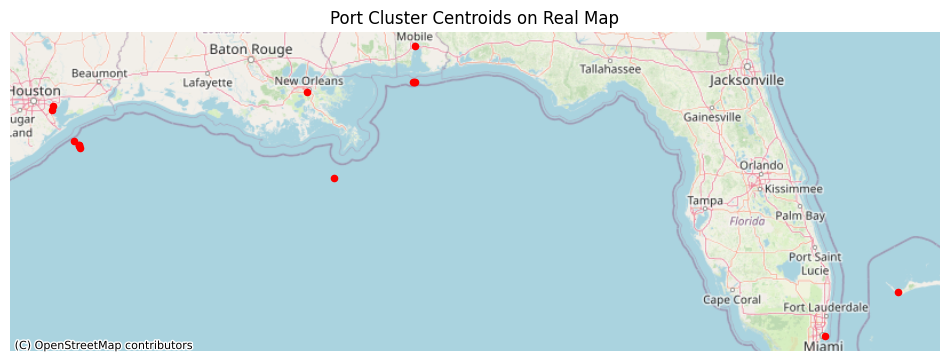

In [11]:
# Create a working copy of the dataframe and ensure correct data types
df_working = df.copy()
df_working['basedatetime'] = pd.to_datetime(df_working['basedatetime'])
df_working['lat'] = df_working['lat'].astype(float)
df_working['lon'] = df_working['lon'].astype(float)

# Filter for stationary points (sog = 0) to detect potential anchorages/stops
df_working = df_working[df_working['sog'] == 0]

# Convert coordinates to radians for haversine distance
coordinates = np.radians(df_working[['lat', 'lon']].to_numpy())

# Apply DBSCAN clustering to group stationary AIS positions
try:
    db = DBSCAN(
        eps=1 / kms_per_radian,      # neighborhood size (converted to radians)
        min_samples=12,              # minimum samples to form a cluster
        metric='haversine'           
    ).fit(coordinates)
    df_working['cluster'] = db.labels_
except MemoryError:
    print("Memory error")

# Calculate centroids of each cluster
centroids = df_working.groupby('cluster')[['lat', 'lon']].mean()

# Find the actual AIS point closest to each centroid
closest_points = []
for cluster_id, centroid in centroids.iterrows():
    cluster_points = df_working[df_working['cluster'] == cluster_id][['lat', 'lon']]
    distances = cdist([centroid.values], cluster_points.values)
    closest_point_idx = distances.argmin()
    closest_points.append(cluster_points.iloc[closest_point_idx])

# Create dataframe of cluster centroid locations
df_port_locations = pd.DataFrame(closest_points)

# Convert to GeoDataFrame for mapping
geometry = [Point(xy) for xy in zip(df_port_locations['lon'], df_port_locations['lat'])]
port_gdf = gpd.GeoDataFrame(df_port_locations, geometry=geometry, crs="EPSG:4326")

# Reproject to Web Mercator 
port_gdf = port_gdf.to_crs(epsg=3857)

# Plot cluster centroids on real-world map
fig, ax = plt.subplots(figsize=(12, 12))
port_gdf.plot(ax=ax, color='red', markersize=20)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.title('Port Cluster Centroids on Real Map')
plt.show()


# **Flag 1: Off Land Stops**

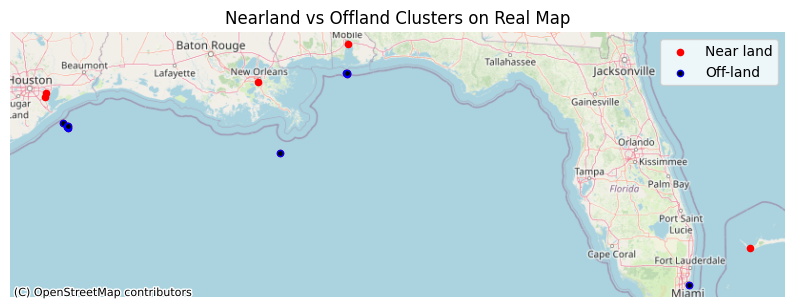

In [12]:
import geopandas as gpd
import contextily as ctx
import zipfile
import io
import requests

# Download and extract Natural Earth land shapefile 
url = "https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("natural_earth_data")

# Load land polygons and reproject to Web Mercator 
land = gpd.read_file("natural_earth_data/ne_10m_land.shp")
land = land.to_crs(epsg=3857)

# Buffer land polygons by 2.5 km 
land_buffered = land.buffer(2500)

# Reproject port clusters to same CRS
port_gdf = port_gdf.to_crs(epsg=3857)

# Check if each port cluster lies within buffered land area
port_gdf['near_land'] = port_gdf.geometry.apply(lambda point: land_buffered.contains(point).any())

# Flag clusters that are too far from land (potential anomalies)
flag1_off_land = port_gdf[~port_gdf['near_land']]

# Plot results: red = valid near-land clusters, black = off-land anomalies
fig, ax = plt.subplots(figsize=(10, 10))
port_gdf.plot(ax=ax, color='red', markersize=20, label='Near land')
flag1_off_land.plot(ax=ax, color='black', edgecolor='blue', markersize=20, label='Off-land')

# Add basemap for context
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Nearland vs Offland Clusters on Real Map')
plt.legend()
ax.set_axis_off()
plt.show()


# **Flag 2: Off Port Stops**

In [13]:
# Filter stopped points outside ports and cluster them
df_working = df.copy()
df_working = df_working[df_working['sog'] == 0]

# Convert to GeoDataFrame
df_working['geometry'] = df_working.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
stopped_gdf = gpd.GeoDataFrame(df_working, geometry='geometry', crs="EPSG:4326")
stopped_gdf = stopped_gdf.to_crs(epsg=3857)

# Buffer ports
port_gdf = port_gdf.to_crs(epsg=3857)
port_gdf['geometry'] = port_gdf.buffer(150)

# Keep points outside port buffers
joined = gpd.sjoin(stopped_gdf, port_gdf[['geometry']], how='left', predicate='within')
flag2_outside_port_stop = joined[joined['index_right'].isna()].copy()

# Ensure numeric types
flag2_outside_port_stop['lat'] = flag2_outside_port_stop['lat'].astype(float)
flag2_outside_port_stop['lon'] = flag2_outside_port_stop['lon'].astype(float)

# Cluster using DBSCAN
coordinates = np.radians(flag2_outside_port_stop[['lat','lon']].to_numpy())
db = DBSCAN(eps=3/kms_per_radian, min_samples=1, metric='haversine').fit(coordinates)
flag2_outside_port_stop['cluster'] = db.labels_

# Count cluster points and label
cluster_sizes = flag2_outside_port_stop['cluster'].value_counts()
flag2_outside_port_stop['count'] = flag2_outside_port_stop['cluster'].map(cluster_sizes)
flag2_outside_port_stop['label'] = flag2_outside_port_stop['count'].apply(lambda x: 'Anchorage' if x>=3 else 'Suspicious')


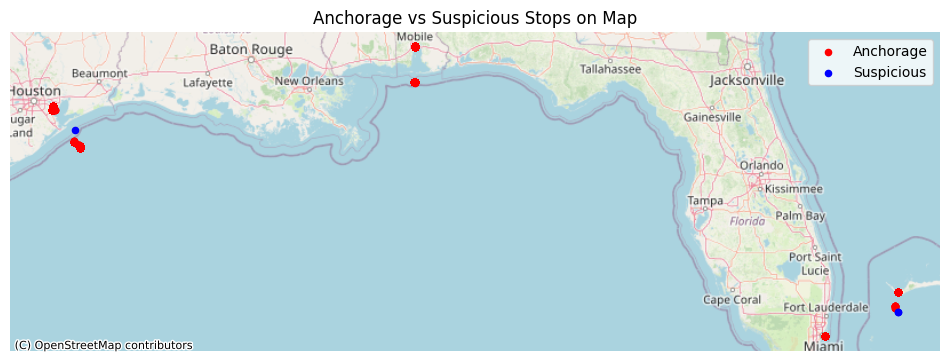

In [14]:
# --- Visualization: Flag 2 (Off-port Stops) ---
# Plot anchorage vs. suspicious off-port stops on a basemap.

flag2_outside_port_stop_gdf = gpd.GeoDataFrame(
    flag2_outside_port_stop,
    geometry=gpd.points_from_xy(flag2_outside_port_stop['lon'], flag2_outside_port_stop['lat']),
    crs="EPSG:4326"
).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))

# Plot anchorage clusters (red) and suspicious isolated stops (blue)
flag2_outside_port_stop_gdf[flag2_outside_port_stop_gdf['label'] == 'Anchorage'].plot(
    ax=ax, color='red', markersize=20, label='Anchorage'
)
flag2_outside_port_stop_gdf[flag2_outside_port_stop_gdf['label'] == 'Suspicious'].plot(
    ax=ax, color='blue', markersize=20, label='Suspicious'
)

# Add basemap and finalize plot
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title('Anchorage vs Suspicious Stops on Map')
plt.legend()
ax.set_axis_off()
plt.show()


# **Flag 3: Missing Data**

In [15]:
# --- Flag 3: Missing Data ---
# Detect unusually long reporting gaps in AIS messages.

df_working = df.copy()
df_working['basedatetime'] = pd.to_datetime(df_working['basedatetime'])
df_working['time_diff'] = df_working['basedatetime'].diff()

# Calculate reporting gap statistics
gap_stats = df_working['time_diff'].agg(['mean', 'std'])
mean_gap = gap_stats['mean']
std_gap = gap_stats['std']
min_gap = pd.Timedelta(days=1)

# Define threshold for abnormal gap (mean + 2*std, but at least 1 day)
threshold = max(mean_gap + 2*std_gap, min_gap)

# Identify rows where gap exceeds threshold
gaps_df = df_working[df_working['time_diff'] > threshold].copy()
gaps_df['gap_start'] = gaps_df['basedatetime'] - gaps_df['time_diff']
gaps_df['gap_end'] = gaps_df['basedatetime']
gaps_df['duration'] = gaps_df['time_diff']

# Label gaps by duration
gaps_df['missing_label'] = gaps_df['duration'].apply(
    lambda x: 'Investigate' if x <= pd.Timedelta(days=10)
    else 'Suspicious' if x <= pd.Timedelta(days=25)
    else 'Ignore'
)

# Store results
flag3_missing_data = gaps_df.copy()


# **Flag 4: Duration** 

In [16]:
# Copy dataframe and filter for vessels that are essentially stopped (sog < 0.5)
df_working = df[df['sog'] < 0.5].copy()
df_working['lat'] = df_working['lat'].astype(float)
df_working['lon'] = df_working['lon'].astype(float)

# Remove points that are less than 5 minutes apart to avoid redundant records
min_gap = pd.Timedelta(minutes=5)
time_mask = (df_working['basedatetime'] - df_working['basedatetime'].shift(1)) >= min_gap
time_mask.iloc[0] = True  
df_working = df_working[time_mask]

# Convert coordinates to radians for haversine distance metric
coordinates = np.radians(df_working[['lat','lon']].to_numpy())

# Cluster stationary points using DBSCAN (eps in radians, min 5 points per cluster)
db = DBSCAN(eps=1/kms_per_radian, min_samples=5, metric='haversine').fit(coordinates)
df_working['cluster'] = db.labels_

# Print the number of clusters found
print(f"Number of unique clusters: {len(df_working['cluster'].unique())}")

df_working = df_working[df_working['cluster'] != -1]


Number of unique clusters: 19


In [17]:
from shapely.geometry import MultiPoint

# Create polygons (convex hulls) around each cluster of stationary points
def create_cluster_polygons(df, cluster_col='cluster'):
    cluster_polygons = {}
    for cluster_id, group in df.groupby(cluster_col):
        # Convert cluster points to a MultiPoint object
        points = MultiPoint(list(zip(group['lon'], group['lat'])))
        # Create convex hull and add a small buffer
        polygon = points.convex_hull.buffer(0.0005)
        cluster_polygons[cluster_id] = polygon
    return cluster_polygons

# Label points as belonging to clusters based on polygon containment
def label_points_by_polygon(cluster_polygons):
    df_idle = df[df['sog'] < 0.5].copy()  # Only consider stopped vessels
    df_idle['basedatetime'] = pd.to_datetime(df_idle['basedatetime'])
    df_idle['geometry'] = df_idle.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
    gdf_idle = gpd.GeoDataFrame(df_idle, geometry='geometry', crs='EPSG:4326')
    
    # Convert cluster polygons to a GeoDataFrame
    poly_list = [{'cluster_id': cid, 'geometry': poly} for cid, poly in cluster_polygons.items()]
    gdf_poly = gpd.GeoDataFrame(poly_list, crs='EPSG:4326')
    
    # Spatial join: label points that fall within a cluster polygon
    joined = gpd.sjoin(gdf_idle, gdf_poly, how='left', predicate='within')
    
    # Keep only points that matched a cluster
    return joined[joined['cluster_id'].notna()].copy()

# Track continuous sessions within the same cluster, splitting at time gaps
def track_sessions_polygons(polygon_df, gap_hours=24):
    polygon_df = polygon_df.sort_values('basedatetime').reset_index(drop=True)

    polygon_df['session_id'] = -1
    current_session = -1
    last_cluster = None
    last_time = None
    gap_seconds = gap_hours * 3600  # convert hours to seconds

    for idx, row in polygon_df.iterrows():
        cluster = row['cluster_id']
        timestamp = row['basedatetime']

        # Start new session if cluster changes or gap exceeds threshold
        if (cluster != last_cluster) or \
           (last_time is not None and (timestamp - last_time).total_seconds() >= gap_seconds):
            current_session += 1

        polygon_df.at[idx, 'session_id'] = current_session
        last_cluster = cluster
        last_time = timestamp

    # Compute start, end, and duration of each session
    polygon_df['start_time'] = polygon_df.groupby('session_id')['basedatetime'].transform('first')
    polygon_df['end_time'] = polygon_df.groupby('session_id')['basedatetime'].transform('last')
    polygon_df['duration'] = (polygon_df['end_time'] - polygon_df['start_time']).dt.total_seconds() / 3600

    return polygon_df


In [18]:
#Call the functions
polygons = create_cluster_polygons(df_working)
polygon_df = label_points_by_polygon(polygons)
flag4_duration = track_sessions_polygons(polygon_df)


In [19]:
# Compute summary statistics for each cluster's duration
cluster_stats = (
    flag4_duration.groupby('cluster_id')['duration']  
    .agg(['mean', 'median', 'std', 'count'])         
    .reset_index()                                    
)

print(cluster_stats)


    cluster_id        mean      median         std  count
0          0.0   18.930398   24.330000    6.861852    840
1          1.0   25.565412   23.062778    3.547315   2465
2          2.0   47.756256   49.865556    5.482136   3367
3          3.0   19.808246   18.620833    7.214433   2847
4          4.0   24.079578   25.993333    6.691953   2687
5          5.0   25.439935   29.390278    5.803328    485
6          6.0   78.926667   78.926667    0.000000   1429
7          7.0   16.395833   16.395833    0.000000    284
8          8.0   83.070233   69.700000   14.412544   2449
9          9.0   25.092500   25.092500    0.000000    444
10        10.0  253.182760  397.722778  168.157624  12790
11        11.0    2.758056    2.758056    0.000000     73
12        12.0    1.583056    1.583056    0.000000     41
13        13.0    4.416667    4.416667    0.000000     75
14        14.0    3.669722    3.669722    0.000000     58
15        15.0   50.335278   50.335278    0.000000    371
16        16.0

In [20]:
flag4_session_stats = flag4_duration[['session_id', 'cluster_id', 'duration']].drop_duplicates()
flag4_session_stats = flag4_session_stats.merge(cluster_stats, on='cluster_id')
# Create overstay flag for instances where the duration exceeds the mean by two standard deviations
flag4_session_stats['overstay_flag'] = flag4_session_stats['duration'] > (flag4_session_stats['median'] + 2 * flag4_session_stats['std'])

# **Flag5: LSTM Model**

In [21]:
# Calculates the haversine distance between two groups of coordinates
def haversine_np(lat1, lon1, lat2, lon2):
    
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return 2*kms_per_radian*np.arcsin(np.sqrt(a))



In [22]:
base_features = ['lat', 'lon', 'sog', 'cog', 'heading', 'basedatetime']

# Creates a DataFrame with selected features
df_working = df[base_features].copy()
df_working['basedatetime'] = pd.to_datetime(df_working['basedatetime'])
df_working = df_working.sort_values('basedatetime').reset_index(drop=True)

selected = []
last_time = None

# Condenses the Dataframe so each row is at least a minute apart
for idx, row in df_working.iterrows(): 
    if last_time is None or (row['basedatetime'] - last_time) >= pd.Timedelta(minutes=1):
        selected.append(idx)
        last_time = row['basedatetime']

df_working = df_working.loc[selected]

In [23]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

big_gap = 168  # Max allowed time delta in hours to avoid extreme gaps

# Ensure numeric types
df_working['lat'] = df_working['lat'].astype(float)
df_working['lon'] = df_working['lon'].astype(float)

# Normalize course over ground and heading
df_working['cog'] = df_working['cog'] % 360
df_working['heading'] = df_working['heading'].replace(511, -1)  # 511 = invalid heading

# Previous positions for distance calculations
lat_prev = df_working['lat'].shift()
lon_prev = df_working['lon'].shift()

# Distance traveled between consecutive points (Haversine)
df_working['distance_traveled'] = haversine_np(lat_prev, lon_prev, df_working['lat'], df_working['lon'])

# Clip extreme distances to remove outliers
q_low = df_working['distance_traveled'].quantile(0.05)
q_high = df_working['distance_traveled'].quantile(0.95)
df_working['distance_traveled'] = df_working['distance_traveled'].clip(lower=q_low, upper=q_high)

# Course and speed changes between consecutive points
df_working['course_change'] = ((df_working['cog'] - df_working['cog'].shift() + 180) % 360 - 180).abs()
df_working['course_change'] = df_working['course_change'].clip(upper=180)

df_working['speed_change'] = abs(df_working['sog'] - df_working['sog'].shift())
df_working['speed_change'] = df_working['speed_change'].clip(upper=30)

df_working['speed_change_signed'] = df_working['sog'] - df_working['sog'].shift()

# Heading change
df_working['heading_change'] = ((df_working['heading'] - df_working['heading'].shift() + 180) % 360 - 180).abs()
df_working['heading_change'] = df_working['heading_change'].clip(upper=180)

# Time difference between consecutive AIS reports in hours
df_working['time_delta'] = df_working['basedatetime'].diff().dt.total_seconds() / 3600
df_working['time_delta'] = df_working['time_delta'].clip(upper=big_gap)

# Acceleration (speed change / time delta)
df_working['acceleration'] = df_working['speed_change'] / df_working['time_delta'].replace([np.inf, -np.inf], np.nan)
df_working['acceleration_signed'] = df_working['speed_change_signed'] / df_working['time_delta'].replace([np.inf, -np.inf], np.nan)

# Handle zero time_delta to avoid division errors
time_delta_mask = df_working['time_delta'] == 0
accel_df = df_working.copy()
accel_df.loc[time_delta_mask, 'acceleration'] = accel_df['acceleration'].shift()[time_delta_mask]
accel_df.loc[time_delta_mask, 'acceleration_signed'] = accel_df['acceleration'].shift()[time_delta_mask]

df_working['acceleration'] = accel_df['acceleration'].fillna(0)
df_working['acceleration_signed'] = accel_df['acceleration_signed'].fillna(0)

# Binary indicator for available heading
df_working['heading_available'] = df_working['heading'].notna().astype(int)

# Fill remaining NaN values with 0
df_working['distance_traveled'] = df_working['distance_traveled'].fillna(0)
df_working['course_change'] = df_working['course_change'].fillna(0)
df_working['speed_change'] = df_working['speed_change'].fillna(0)
df_working['speed_change_signed'] = df_working['speed_change_signed'].fillna(0)
df_working['time_delta'] = df_working['time_delta'].fillna(0)
df_working['heading_change'] = df_working['heading_change'].fillna(0)

# Compute distance from nearest known port/anchorage
distances = []
for _, port in df_port_locations.iterrows():
    distances.append(haversine_np(port['lat'], port['lon'], df_working['lat'], df_working['lon']))
df_working['distance_from_coast'] = np.min(np.array(distances), axis=0)

# List of features used for anomaly detection / modeling
features = ['lat', 'lon', 'sog', 'cog', 'heading', 'course_change', 'speed_change',
            'distance_traveled', 'heading_change', 'acceleration', 'distance_from_coast', 'heading_available',
            'speed_change_signed', 'acceleration_signed', 'time_delta']


In [24]:
seq_length = 50          # Standard sequence length for LSTM
max_gap_hours = 48       # Maximum allowed gap between AIS points in a sequence

# Mask large gaps in time to avoid unrealistic transitions
scaler = MinMaxScaler()
gap_mask = df_working['time_delta'] > big_gap
features_to_mask = ['lat', 'lon', 'sog', 'cog', 'heading', 'course_change', 'speed_change',
                    'distance_traveled', 'heading_change', 'acceleration', 'distance_from_coast', 
                    'heading_available', 'speed_change_signed', 'acceleration_signed', 'time_delta']

# Replace features with -1 for large time gaps (will be ignored during scaling)
df_working.loc[gap_mask, features_to_mask] = -1.0

# Copy dataframe for LSTM preprocessing
df_lstm = df_working.copy()
print(f"Size of df: {len(df_lstm)}")

# Prepare storage for sequences
all_sequences = []
sequence_lengths = []

# Function to convert a segment of AIS points into LSTM sequences
def add_segment(segment):
    if len(segment) >= 10:  # Skip very short segments
        seg = segment.copy()

        # Scale each feature independently, ignoring masked values (-1)
        for col in features:
            valid_mask = seg[col] != -1.0
            if valid_mask.any():
                scaler = MinMaxScaler()
                seg.loc[valid_mask, col] = scaler.fit_transform(seg.loc[valid_mask, [col]])

        data_scaled = seg[features]
        start_time = segment['basedatetime'].iloc[0]
        end_time   = segment['basedatetime'].iloc[-1]

        # Split segment into sliding windows of seq_length
        if len(data_scaled) >= seq_length:
            for j in range(len(data_scaled) - seq_length + 1):
                all_sequences.append({
                    "start_time": start_time,
                    "end_time": end_time,
                    "data": data_scaled[j:j+seq_length],
                    "seq_start_time": segment['basedatetime'].iloc[j],
                    "seq_end_time": segment['basedatetime'].iloc[j + seq_length - 1]
                })
                sequence_lengths.append(seq_length)
        else:
            # Keep shorter sequences as they are
            all_sequences.append({
                "start_time": start_time,
                "end_time": end_time,
                "data": data_scaled,
                "seq_start_time": segment['basedatetime'].iloc[0],
                "seq_end_time": segment['basedatetime'].iloc[-1]
            })
            sequence_lengths.append(len(data_scaled))

# Segment dataframe based on gaps larger than max_gap_hours
start_idx = 0
for i in range(1, len(df_lstm)):
    if df_lstm.iloc[i]['time_delta'] > max_gap_hours:
        segment = df_lstm.iloc[start_idx:i]
        add_segment(segment)
        start_idx = i

# Add the final segment
segment = df_lstm.iloc[start_idx:]
add_segment(segment)

# Summary of sequences
print(f"Number of sequences: {len(all_sequences)}")
print(f"Sequence lengths - Min: {min(sequence_lengths)}, Max: {max(sequence_lengths)}")
print(f"Total sequences of length 50: {sum(1 for x in sequence_lengths if x == 50)}")
print(f"Total short sequences: {sum(1 for x in sequence_lengths if x < 50)}")


Size of df: 89045


C:\Users\danib\AppData\Local\Temp\ipykernel_19600\4208154798.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.9637883  0.95543175 0.95821727 ... 0.30640669 0.24233983 0.39554318]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seg.loc[valid_mask, col] = scaler.fit_transform(seg.loc[valid_mask, [col]])
C:\Users\danib\AppData\Local\Temp\ipykernel_19600\4208154798.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.96153846 1.         0.96153846 0.96153846 0.96153846 0.96153846
 0.96153846 1.         0.92307692 1.         0.96153846 0.96153846
 0.96153846 0.96153846 0.96153846 0.96153846 0.96153846 0.96153846
 0.96153846 0.96153846 0.96153846 0.96153846 0.96153846 0.96153846
 0.96153846 0.96153846 0.96153846 1.         0.96153846 0.03846154
 0.03846154 0.07692308 0.03846154

Number of sequences: 88357
Sequence lengths - Min: 50, Max: 50
Total sequences of length 50: 88357
Total short sequences: 0


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Masking, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert list of sequences into numpy arrays for model input
sequence_data = [seq["data"].to_numpy(dtype="float32") for seq in all_sequences]

# Determine maximum sequence length to pad all sequences consistently
max_len = max(len(seq) for seq in sequence_data)

# Pad sequences to have uniform length (post-padding with -1.0 as mask value)
X_padded = pad_sequences(sequence_data, maxlen=max_len, dtype='float32', padding='post', value=-1.0)

# Debug
print("Shape after padding:", X_padded.shape)
print("Any NaN in X_padded?", np.isnan(X_padded).any())
print("Any Inf in X_padded?", np.isinf(X_padded).any())
print("Min, Max values:", np.nanmin(X_padded), np.nanmax(X_padded))

# Split indices into training (80%) and test (20%) sets
all_idx = np.arange(len(all_sequences))
train_size = int(len(all_idx) * 0.8)
train_idx, test_idx = all_idx[:train_size], all_idx[train_size:]

# Slice padded sequences into training and testing sets
X_train, X_test = X_padded[train_idx], X_padded[test_idx]

# Capture the sequence dimensions for model input
timesteps = X_train.shape[1]      # number of time steps in a sequence
num_features = X_train.shape[2]   # number of features per time step

# Define LSTM autoencoder model
model = Sequential([
    Input(shape=(timesteps, num_features)),
    Masking(mask_value=-1.0),   
    LSTM(64, activation="tanh", return_sequences=False),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(64, activation="tanh", return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))
])

# Compile model using mean squared error loss
model.compile(optimizer=Adam(), loss='mse')

model.summary()


Shape after padding: (88357, 50, 15)
Any NaN in X_padded? False
Any Inf in X_padded? False
Min, Max values: -1.0 1.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 50, 15)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 15)         │           975 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,479 (212.81 KB)

 Trainable params: 54,479 (212.81 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(
    X_train, X_train,   
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    shuffle=False
)


Epoch 1/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 62s 58ms/step - loss: 0.0408 - val_loss: 0.0073
Epoch 2/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 59s 59ms/step - loss: 0.0178 - val_loss: 0.0049
Epoch 3/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 60s 61ms/step - loss: 0.0142 - val_loss: 0.0046
Epoch 4/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - loss: 0.0126 - val_loss: 0.0049
Epoch 5/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 61s 61ms/step - loss: 0.0119 - val_loss: 0.0041
Epoch 6/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - loss: 0.0114 - val_loss: 0.0039
Epoch 7/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - loss: 0.0112 - val_loss: 0.0041
Epoch 8/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 56s 56ms/step - loss: 0.0106 - val_loss: 0.0039
Epoch 9/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - loss: 0.0104 - val_loss: 0.0035
Epoch 10/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step - loss: 0.0101 - val_loss: 0.0042


In [27]:
X_test_pred = model.predict(X_padded)
X_test_pred = X_test_pred.reshape(X_test_pred.shape[0], X_test_pred.shape[1], len(features))

# Compute Mean Squared Error (MSE) for each sequence between actual and reconstructed values
mse = np.mean(np.power(X_padded - X_test_pred, 2), axis=(1, 2))

# Define anomaly threshold as mean MSE + 3 standard deviations
threshold = np.mean(mse) + 3 * np.std(mse)
print(f"Anomaly threshold: {threshold}")

# Flag sequences with MSE above threshold as anomalies
anomalies = mse > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")


2762/2762 ━━━━━━━━━━━━━━━━━━━━ 46s 16ms/step
Anomaly threshold: 0.041855793446302414
Number of anomalies detected: 1268


In [28]:
# Assign MSE and anomaly flag to each sequence
for i, seq in enumerate(all_sequences):
    seq["mse"] = mse[i] 
    seq["is_anomaly"] = mse[i] > threshold  

# Extract unique date ranges of all sequences
unique_seq_dates = {
    (s["seq_start_time"].date(), s["seq_end_time"].date())
    for s in all_sequences
}

# Sort the unique sequences by start date
unique_seq_dates = sorted(list(unique_seq_dates), key=lambda x: x[0])

print(f"Unique sequences near accident: {len(unique_seq_dates)}")
for start_date, end_date in unique_seq_dates:
    print(f"Start: {start_date}, End: {end_date}")


Unique sequences near accident: 303
Start: 2021-05-06, End: 2021-05-06
Start: 2021-05-06, End: 2021-05-07
Start: 2021-05-07, End: 2021-05-07
Start: 2021-05-07, End: 2021-05-08
Start: 2021-05-08, End: 2021-05-09
Start: 2021-05-08, End: 2021-05-08
Start: 2021-05-09, End: 2021-05-10
Start: 2021-05-09, End: 2021-05-09
Start: 2021-05-10, End: 2021-05-11
Start: 2021-05-10, End: 2021-05-10
Start: 2021-05-11, End: 2021-05-12
Start: 2021-05-11, End: 2021-05-11
Start: 2021-05-12, End: 2021-05-13
Start: 2021-05-12, End: 2021-05-12
Start: 2021-05-13, End: 2021-05-13
Start: 2021-05-13, End: 2021-05-14
Start: 2021-05-14, End: 2021-05-15
Start: 2021-05-14, End: 2021-05-14
Start: 2021-05-15, End: 2021-05-15
Start: 2021-05-15, End: 2021-05-16
Start: 2021-05-16, End: 2021-05-17
Start: 2021-05-16, End: 2021-05-16
Start: 2021-05-17, End: 2021-05-18
Start: 2021-05-17, End: 2021-05-17
Start: 2021-05-18, End: 2021-05-19
Start: 2021-05-18, End: 2021-05-18
Start: 2021-05-19, End: 2021-05-21
Start: 2021-05-19, 

In [29]:
# Merge overlapping or consecutive sequence date ranges into continuous segments
segments = []
current_start, current_end = unique_seq_dates[0]

for start, end in unique_seq_dates[1:]:
    #overlapping sequences = extend final date
    if start <= current_end:  
        current_end = max(current_end, end)
    else:
        #non overlapping save previous segment before starting a new one
        segments.append((current_start, current_end))
        current_start, current_end = start, end


segments.append((current_start, current_end))

print("Merged segments:")
for s, e in segments:
    print(f"Segment: {s} → {e}")


Merged segments:
Segment: 2021-05-06 → 2021-05-21
Segment: 2021-06-05 → 2021-06-06
Segment: 2021-07-03 → 2021-07-07
Segment: 2021-07-16 → 2021-07-28
Segment: 2021-08-08 → 2021-08-11
Segment: 2021-09-22 → 2021-09-24
Segment: 2021-10-04 → 2021-10-25
Segment: 2021-11-07 → 2021-11-09
Segment: 2021-12-27 → 2022-01-14
Segment: 2022-03-21 → 2022-05-02
Segment: 2022-06-11 → 2022-06-18
Segment: 2022-08-03 → 2022-08-10
Segment: 2022-09-29 → 2022-10-06
Segment: 2022-11-29 → 2022-12-08


# **Cross-Analysis**

In [30]:
#intialize the final result DataFrame
final_anom_dates = pd.DataFrame(columns=["start_date", "end_date", "anomalous_score"])


In [31]:
from haversine import haversine
#Locate all teh points that were within 2km of off land port locations from flag 1
analysis_df = df.copy()
analysis_df = analysis_df[analysis_df['sog'] ==0]
analysis_df['off_land'] = analysis_df.apply(
    lambda row: any(
        haversine((row['lat'], row['lon']), (lat, lon)) <= 2
        for lat, lon in flag1_off_land[['lat', 'lon']].to_numpy()
    ),
    axis=1
)



In [32]:
# Function to calculate average speed change before and after a target period
def calculate_speed_changes(target_df, df_working, time_window_hours=1):
    df_working = df_working.copy()
    df_working['basedatetime'] = pd.to_datetime(df_working['basedatetime'])
    speed_list = []

    for idx, row in target_df.iterrows():
        # Define start and end times of the target period
        start_idx = row['start_index']
        end_idx   = row['last_index']
        start_time = df_working.loc[start_idx, 'basedatetime']
        end_time   = df_working.loc[end_idx, 'basedatetime']

        # Define time windows before and after the target period
        time_before = start_time - pd.Timedelta(hours=time_window_hours)
        time_after  = end_time + pd.Timedelta(hours=time_window_hours)

        # Extract the "before" and "after" slices
        before_df = df_working[(df_working['basedatetime'] >= time_before) &
                               (df_working['basedatetime'] <= start_time)]
        after_df = df_working[(df_working['basedatetime'] >= end_time) &
                              (df_working['basedatetime'] <= time_after)]

        # Calculate speed change rates for before and after periods
        for label, sub_df in [('before', before_df), ('after', after_df)]:
            if len(sub_df) > 1:
                sub_df = sub_df.copy()
                sub_df['sog_diff'] = sub_df['sog'].diff()
                sub_df['time_diff'] = sub_df['basedatetime'].diff().dt.total_seconds() / 3600

                # Average speed change per hour
                sog_diff = sub_df['sog_diff'].mean()
                period = sub_df['time_diff'].mean()
                difference = sog_diff / period if period > 0 else None

                # Use session ID if available, else default to index
                session_id = row.get('off_land_new_session', idx)

                speed_list.append({
                    'session_id': session_id, 
                    'period': label, 
                    'speed_change_rate': difference
                })
            else:
                session_id = row.get('off_land_new_session', idx)
                print(f"session: {session_id} | {label} | insufficient data")

    return speed_list

# Function to merge calculated speed changes back into the target dataframe
def apply_speed_changes_to_df(target_df, speed_list):
    result_df = target_df.copy()
    result_df.loc[:, 'before'] = None
    result_df.loc[:, 'after'] = None

    for row in speed_list:
        session_id = row['session_id']
        
        # Match by session ID or index
        if 'off_land_new_session' in result_df.columns:
            mask = result_df['off_land_new_session'] == session_id
        else:
            mask = result_df.index == session_id
        
        if mask.any():
            if row['period'] == 'before':
                result_df.loc[mask, 'before'] = row['speed_change_rate']
            else:
                result_df.loc[mask, 'after'] = row['speed_change_rate']

    return result_df


In [33]:
# Merge port locations with off-land clusters to remove off-land points
df_new = df_port_locations.merge(flag1_off_land, on=["lat", "lon"], how="left", indicator=True)

# Keep only points that are NOT in the off-land set
df_new = df_new[df_new["_merge"] == "left_only"].drop(columns="_merge")

# Add a boolean column to analysis_df indicating whether each point is on land
analysis_df['on_land'] = analysis_df.apply(
    lambda row: any(
        haversine((row['lat'], row['lon']), (lat, lon)) <= 2
        for lat, lon in df_new[['lat', 'lon']].to_numpy()
    ),
    axis=1
)


In [34]:
import pandas as pd

# Define maximum gaps for off-land and on-land sessions
max_gap_off = pd.Timedelta(hours=168)  # 1 week
max_gap_on  = pd.Timedelta(hours=48)   

# --- OFF-LAND SESSIONS ---
# Filter off-land points and sort by time
f_df = analysis_df[analysis_df['off_land']].copy().sort_values('basedatetime')
f_df['time_diff'] = f_df['basedatetime'].diff()

# Assign session IDs based on time gap
f_df['off_land_new_session'] = (f_df['time_diff'] > max_gap_off).cumsum()

# --- ON-LAND SESSIONS ---
# Filter on-land points and sort by time
l_df = analysis_df[analysis_df['on_land']].copy().sort_values('basedatetime')
l_df['time_diff'] = l_df['basedatetime'].diff()

# Assign session IDs based on time gap
l_df['on_land_new_session'] = (l_df['time_diff'] > max_gap_on).cumsum()

# --- MERGE SESSION INFO BACK ---
analysis_df = analysis_df.merge(
    f_df[['basedatetime','off_land_new_session']], 
    on='basedatetime', how='left'
)
analysis_df = analysis_df.merge(
    l_df[['basedatetime','on_land_new_session']], 
    on='basedatetime', how='left'
)

# --- CALCULATE SESSION TIMES ---
# Off-land session times
off_session_times = (
    f_df.groupby('off_land_new_session')
        .agg(start_time=('basedatetime','min'),
             end_time=('basedatetime','max'))
        .reset_index()
)
off_session_times['time_spent'] = off_session_times['end_time'] - off_session_times['start_time']
off_session_times['type'] = 'off_land'

# On-land session times
on_session_times = (
    l_df.groupby('on_land_new_session')
        .agg(start_time=('basedatetime','min'),
             end_time=('basedatetime','max'))
        .reset_index()
)
on_session_times['time_spent'] = on_session_times['end_time'] - on_session_times['start_time']
on_session_times['type'] = 'on_land'

# Combine all sessions
session_times = pd.concat([off_session_times, on_session_times])


In [35]:
session_times['start_time'] = pd.to_datetime(session_times['start_time'])
session_times['end_time'] = pd.to_datetime(session_times['end_time'])

session_times = session_times.sort_values('start_time')

# For off-land sessions, find the next on-land session start time
session_times['next_on_land_start'] = session_times.apply(
    lambda row: session_times[
        (session_times['type'] == 'on_land') & 
        (session_times['start_time'] > row['end_time'])
    ]['start_time'].min() if row['type'] == 'off_land' else pd.NaT,
    axis=1
)

# Calculate the gap in days between off-land session end and next on-land start
session_times['gap_days'] = (
    session_times['next_on_land_start'] - session_times['end_time']
).dt.total_seconds() / (3600*24)

session_times['classification'] = ''

# Classify off-land sessions with gap <= 5 days as 'Anchorage'
session_times.loc[
    (session_times['type'] == 'off_land') & 
    (session_times['gap_days'].notna()) & 
    (session_times['gap_days'] <= 5) & 
    (session_times['gap_days'] >= 0),
    'classification'
] = 'Anchorage'


In [36]:
# Initialize columns to store the first and last index of each session
session_times['start_index'] = None
session_times['last_index'] = None

# Assign start and end indices for off-land sessions
for session_id, group in f_df.groupby('off_land_new_session'):
    if not pd.isna(session_id):
        first_index = group.index[0]
        last_index = group.index[-1]

        # Update the corresponding rows in session_times
        mask = (session_times['off_land_new_session'] == session_id) & (session_times['type'] == 'off_land')
        session_times.loc[mask, 'start_index'] = first_index
        session_times.loc[mask, 'last_index'] = last_index

# Prepare on-land dataframe
on_land_df = analysis_df[~analysis_df['off_land']].copy()
on_land_df = on_land_df.sort_values('basedatetime')

# Assign start and end indices for on-land sessions
for session_id, group in on_land_df.groupby('on_land_new_session'):
    if not pd.isna(session_id):
        first_index = group.index[0]
        last_index = group.index[-1]

        # Update the corresponding rows in session_times
        mask = (session_times['on_land_new_session'] == session_id) & (session_times['type'] == 'on_land')
        session_times.loc[mask, 'start_index'] = first_index
        session_times.loc[mask, 'last_index'] = last_index

# Print summary of all sessions
for _, row in session_times.iterrows():
    session_type = row['type']
    if session_type == 'off_land':
        session_num = row['off_land_new_session']
    else:
        session_num = row['on_land_new_session']

    print(f"{session_type} session id: {session_num}, first: {row['start_index']}, last: {row['last_index']}")


off_land session id: 0.0, first: 165, last: 371
on_land session id: 0.0, first: 308, last: 1760
off_land session id: 1.0, first: 6171, last: 6688
off_land session id: 2.0, first: 13556, last: 13625
on_land session id: 1.0, first: 2347, last: 3785
off_land session id: 3.0, first: 19791, last: 20182
on_land session id: 2.0, first: 4120, last: 4299
off_land session id: 4.0, first: 27035, last: 31370
on_land session id: 3.0, first: 4459, last: 4898
on_land session id: 4.0, first: 5665, last: 6959
off_land session id: 5.0, first: 37102, last: 36256
on_land session id: 5.0, first: 7536, last: 7552
off_land session id: 6.0, first: 38981, last: 47076
on_land session id: 6.0, first: 7751, last: 8312
on_land session id: 7.0, first: 8730, last: 9762
on_land session id: 8.0, first: 10321, last: 10328
on_land session id: 9.0, first: 10329, last: 10839
off_land session id: 7.0, first: 49846, last: 53829
on_land session id: 10.0, first: 11156, last: 12213
on_land session id: 11.0, first: 12892, last:

In [37]:
# Select off-land sessions that are either unclassified or last more than 5 days
anom_df = session_times[
    (session_times['classification'] == "") | 
    (session_times['time_spent'] > pd.Timedelta(days=5))
]
anom_df = anom_df[anom_df['type'] == 'off_land']  # focus on off-land sessions only
print(anom_df)

# Separate sessions into 'Anchorage' and non-anchored
anchored_df = anom_df[anom_df['classification'] == 'Anchorage']
non_anchor_df = anom_df[anom_df['classification'] == '']

# Calculate speed changes before and after anchored sessions
speed_list_anchored = calculate_speed_changes(anchored_df, df, time_window_hours=0.5)
anchored_df = apply_speed_changes_to_df(anchored_df, speed_list_anchored)

# Calculate speed changes before and after non-anchored sessions
speed_list_non_anchor = calculate_speed_changes(non_anchor_df, df, time_window_hours=1.0)
non_anchor_df = apply_speed_changes_to_df(non_anchor_df, speed_list_non_anchor)


   off_land_new_session          start_time            end_time  \
1                   1.0 2021-05-17 08:24:21 2021-05-18 10:13:15   
4                   4.0 2021-10-05 22:09:58 2021-10-12 02:52:22   
6                   6.0 2021-12-28 09:39:11 2022-01-12 16:44:42   
7                   7.0 2022-03-24 17:52:17 2022-03-31 11:12:33   

        time_spent      type  on_land_new_session  next_on_land_start  \
1  1 days 01:48:54  off_land                  NaN 2021-07-17 15:35:23   
4  6 days 04:42:24  off_land                  NaN 2021-10-12 11:13:04   
6 15 days 07:05:31  off_land                  NaN 2022-01-14 05:29:21   
7  6 days 17:20:16  off_land                  NaN 2022-04-04 10:51:47   

    gap_days classification start_index last_index  
1  60.223704                       6171       6688  
4   0.347708      Anchorage       27035      31370  
6   1.531007      Anchorage       38981      47076  
7   3.985579      Anchorage       49846      53829  


In [38]:
# Compute mean and standard deviation of speed changes before and after anchored sessions
before_sog_diff = anchored_df['before'].mean()
after_sog_diff = anchored_df['after'].mean()
before_sog_std = anchored_df['before'].std()
after_sog_std = anchored_df['after'].std()

# Define thresholds for anomalous speed changes
before_threshold = before_sog_diff - before_sog_std   
after_threshold = after_sog_diff + after_sog_std      

print(f'Before threshold: {before_threshold}')
print(f'After threshold: {after_threshold}')

# Label sessions as anomalous if they exceed thresholds
anchored_df.loc[:, 'anomalous_before'] = anchored_df['before'] < before_threshold
anchored_df.loc[:, 'anomalous_after'] = anchored_df['after'] > after_threshold

# Compute a combined anomaly score 
anchored_df.loc[:, 'anomalous_score'] = (
    anchored_df['anomalous_before'].astype(int) + 
    anchored_df['anomalous_after'].astype(int)
)


Before threshold: -15.86848670729497
After threshold: 21.599381120029197


In [39]:
non_anchor_df.loc[:, 'anomalous_score'] = 0

# Iterate over each non-anchored session
for _, row in non_anchor_df.iterrows():
    end_time = pd.to_datetime(row['end_time'])
    next_land_start = pd.to_datetime(row['next_on_land_start'])

    # Select gaps that occur between the end of this session and the next on-land start
    mask = (
        (flag3_missing_data['gap_start'] >= end_time) &
        (flag3_missing_data['gap_end'] <= next_land_start)
    )
    matching_gaps = flag3_missing_data[mask]

    # Sum durations of all gaps in this window
    total_duration = matching_gaps['duration'].sum()
    print(f"Total duration of gaps: {total_duration}, session gap_days: {row['gap_days']}")

    # If total duration exceeds half of the session gap_days, increment anomaly score
    if total_duration > pd.Timedelta(row['gap_days'] / 2):
        non_anchor_df.loc[:, 'anomalous_score'] += 1


Total duration of gaps: 51 days 17:39:42, session gap_days: 60.223703703703706


In [40]:
# Combine non-anchored and anchored anomaly results into a single dataframe
anomaly_results = pd.concat([
    non_anchor_df.drop(columns=['on_land_new_session']),
    anchored_df.drop(columns=['on_land_new_session']),
])

print(anomaly_results)

# Initialize final dataframe if not already defined
if 'final_anom_dates' not in globals():
    final_anom_dates = pd.DataFrame(columns=["start_date", "end_date", "anomalous_score"])

# Iterate through all anomaly results
for _, row in anomaly_results.iterrows():
    # Only keep rows where anomaly score > 0
    if row['anomalous_score'] > 0:
        new_row = pd.DataFrame([{
            "start_date": row['start_time'],
            "end_date": row['end_time'],
            "anomalous_score": row['anomalous_score']
        }])
        # Append to final anomalies dataframe
        final_anom_dates = pd.concat([final_anom_dates, new_row], ignore_index=True)

print(final_anom_dates)


   off_land_new_session          start_time            end_time  \
1                   1.0 2021-05-17 08:24:21 2021-05-18 10:13:15   
4                   4.0 2021-10-05 22:09:58 2021-10-12 02:52:22   
6                   6.0 2021-12-28 09:39:11 2022-01-12 16:44:42   
7                   7.0 2022-03-24 17:52:17 2022-03-31 11:12:33   

        time_spent      type  next_on_land_start   gap_days classification  \
1  1 days 01:48:54  off_land 2021-07-17 15:35:23  60.223704                  
4  6 days 04:42:24  off_land 2021-10-12 11:13:04   0.347708      Anchorage   
6 15 days 07:05:31  off_land 2022-01-14 05:29:21   1.531007      Anchorage   
7  6 days 17:20:16  off_land 2022-04-04 10:51:47   3.985579      Anchorage   

  start_index last_index     before      after  anomalous_score  \
1        6171       6688 -11.570341  10.372028                1   
4       27035      31370       -1.6  11.993107                0   
6       38981      47076       -0.4  14.541258                0   
7    

C:\Users\danib\AppData\Local\Temp\ipykernel_19600\3281946693.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_anom_dates = pd.concat([final_anom_dates, new_row], ignore_index=True)


In [41]:
# Iterate over all unique LSTM sequences
for seq_start, seq_end in unique_seq_dates:
    
    # Find rows in final_anom_dates that overlap with the current LSTM sequence
    mask = (final_anom_dates['start_date'].dt.date <= seq_end) & \
           (final_anom_dates['end_date'].dt.date >= seq_start)
    
    # If any overlapping anomalies are found, increment their anomaly score
    if mask.any():
        final_anom_dates.loc[mask, 'anomalous_score'] += 1
        print(f"LSTM sequence {seq_start} to {seq_end} overlaps with anomaly ranges - scores incremented")
        
        # Print affected ranges and their updated scores for verification
        affected_ranges = final_anom_dates.loc[mask, ['start_date', 'end_date', 'anomalous_score']]
        for _, row in affected_ranges.iterrows():
            print(f"  Affected range: {row['start_date'].date()} to {row['end_date'].date()}, "
                  f"new score: {row['anomalous_score']}")


LSTM sequence 2021-05-16 to 2021-05-17 overlaps with anomaly ranges - scores incremented
  Affected range: 2021-05-17 to 2021-05-18, new score: 2
LSTM sequence 2021-05-17 to 2021-05-18 overlaps with anomaly ranges - scores incremented
  Affected range: 2021-05-17 to 2021-05-18, new score: 3
LSTM sequence 2021-05-17 to 2021-05-17 overlaps with anomaly ranges - scores incremented
  Affected range: 2021-05-17 to 2021-05-18, new score: 4
LSTM sequence 2021-05-18 to 2021-05-19 overlaps with anomaly ranges - scores incremented
  Affected range: 2021-05-17 to 2021-05-18, new score: 5
LSTM sequence 2021-05-18 to 2021-05-18 overlaps with anomaly ranges - scores incremented
  Affected range: 2021-05-17 to 2021-05-18, new score: 6
LSTM sequence 2022-03-23 to 2022-03-24 overlaps with anomaly ranges - scores incremented
  Affected range: 2022-03-24 to 2022-03-31, new score: 3
LSTM sequence 2022-03-24 to 2022-03-24 overlaps with anomaly ranges - scores incremented
  Affected range: 2022-03-24 to 202

In [42]:
# Define the maximum gap in hours to consider in-between sessions
gap_hours = 12
target_dates = []

# Filter sessions where the gap to the next on-land session is smaller than the threshold
inbetween_sesh = session_times[session_times['gap_days'] < (gap_hours / 24)]  

# Keep only sessions where the end date and the next on-land start date are the same
inbetween_sesh = inbetween_sesh[
    inbetween_sesh['end_time'].dt.date == inbetween_sesh['next_on_land_start'].dt.date
]

# Exclude off-land sessions already marked as anomalous
inbetween_sesh = inbetween_sesh[
    ~inbetween_sesh['off_land_new_session'].isin(anom_df['off_land_new_session'])
]

# Iterate through unique target dates
for target_date in inbetween_sesh['next_on_land_start'].dt.date.unique():

    # Find LSTM sequences that start and end on the same target date
    matching_seqs = [
        (s, e) for (s, e) in unique_seq_dates
        if s == target_date and e == target_date
    ]
    
    if matching_seqs:
        print(f"Target date {target_date} is both start and end in {len(matching_seqs)} sequence(s):")
        target_dates.append(target_date)
        for s, e in matching_seqs:
            print(f"  Start: {s}, End: {e}")
    else:
        print(f"Target date {target_date} not found as both start and end.")


Target date 2021-05-08 is both start and end in 1 sequence(s):
  Start: 2021-05-08, End: 2021-05-08
Target date 2021-07-17 is both start and end in 1 sequence(s):
  Start: 2021-07-17, End: 2021-07-17
Target date 2021-07-27 is both start and end in 1 sequence(s):
  Start: 2021-07-27, End: 2021-07-27
Target date 2022-04-14 is both start and end in 1 sequence(s):
  Start: 2022-04-14, End: 2022-04-14


In [43]:
final_anom_dates['start_date'] = pd.to_datetime(final_anom_dates['start_date'])
final_anom_dates['end_date'] = pd.to_datetime(final_anom_dates['end_date'])

# Iterate through all target dates identified from in-between sessions
for date in target_dates:
    # Find existing anomaly ranges that include the target date
    mask = (final_anom_dates['start_date'].dt.date <= date) & \
           (final_anom_dates['end_date'].dt.date >= date)

    if mask.any():  
        # If the target date overlaps an existing anomaly, increment its score
        final_anom_dates.loc[mask, 'anomalous_score'] += 1
    else:
        # If no overlap exists, create a new anomaly record for that date
        new_row = {
            "start_date": pd.to_datetime(date),
            "end_date": pd.to_datetime(date),
            "anomalous_score": 1
        }
        final_anom_dates = pd.concat([final_anom_dates, pd.DataFrame([new_row])], ignore_index=True)


In [44]:
df_working = flag2_outside_port_stop.copy()

df_working['basedatetime'] = pd.to_datetime(df_working['basedatetime'])

# Calculate the time difference 
df_working['time_diff'] = df_working['basedatetime'].diff().dt.total_seconds() / 3600

max_gap = 48

# Create segment IDs: each time the gap exceeds max_gap, increment the segment counter
df_working['segment_id'] = (df_working['time_diff'] > max_gap).cumsum()

# Aggregate segment information: start and end times, and first/last row indices
segments = df_working.groupby('segment_id').agg(
    start_time=('basedatetime', 'first'),      
    end_time=('basedatetime', 'last'),         
    start_index=('basedatetime', lambda x: x.index[0]),  
    last_index=('basedatetime', lambda x: x.index[-1])  
)

print(segments.head())


                    start_time            end_time  start_index  last_index
segment_id                                                                 
0          2021-05-07 07:02:39 2021-05-08 06:17:41          165         371
1          2021-05-10 20:45:18 2021-05-12 18:46:45         2302        3637
2          2021-07-17 06:47:19 2021-07-18 13:02:23        13556       14317
3          2021-07-26 11:22:56 2021-07-27 04:10:56        19791       20182
4          2021-10-06 10:00:58 2021-10-06 10:57:58        27823       27837


In [45]:
import pandas as pd

segs_df = segments.copy()

# Ensure datetime columns in anomalies are proper datetime objects
final_anom_dates['start_date'] = pd.to_datetime(final_anom_dates['start_date'], errors='coerce')
final_anom_dates['end_date'] = pd.to_datetime(final_anom_dates['end_date'], errors='coerce')
final_anom_dates = final_anom_dates.sort_values('start_date').reset_index(drop=True)

# Ensure anomalous_score is numeric and fill any NaNs with 0
final_anom_dates['anomalous_score'] = pd.to_numeric(final_anom_dates['anomalous_score'], errors='coerce').fillna(0).astype(int)

# Convert segment start/end times to datetime
segs_df['start_time'] = pd.to_datetime(segs_df['start_time'], errors='coerce')
segs_df['end_time'] = pd.to_datetime(segs_df['end_time'], errors='coerce')

# Initialize list to hold segments that do not overlap with any anomalies
remaining_segments = []

# Check each segment against all anomaly ranges
for _, seg in segs_df.iterrows():
    s_start, s_end = seg['start_time'], seg['end_time']

    # Mask for anomalies that overlap with the segment
    mask = (final_anom_dates['start_date'] <= s_end) & (final_anom_dates['end_date'] >= s_start)

    if mask.any():
        # If overlapping, increment the anomalous_score
        final_anom_dates.loc[mask, 'anomalous_score'] += 1
    else:
        # Otherwise, keep segment in the remaining list
        remaining_segments.append(seg)

# Convert remaining segments into a DataFrame
remaining_segments_df = pd.DataFrame(remaining_segments)

# Merge overlapping anomaly ranges and sum their scores
merged = []
if len(final_anom_dates) > 0:
    cur_start = final_anom_dates.loc[0, 'start_date']
    cur_end   = final_anom_dates.loc[0, 'end_date']
    cur_score = int(final_anom_dates.loc[0, 'anomalous_score'])

    for i in range(1, len(final_anom_dates)):
        s, e, sc = final_anom_dates.loc[i, 'start_date'], final_anom_dates.loc[i, 'end_date'], int(final_anom_dates.loc[i, 'anomalous_score'])

        if s <= cur_end:  
            cur_end = max(cur_end, e)
            cur_score += sc
        else:
            merged.append({'start_date': cur_start, 'end_date': cur_end, 'anomalous_score': cur_score})
            cur_start, cur_end, cur_score = s, e, sc

    # Append the last range
    merged.append({'start_date': cur_start, 'end_date': cur_end, 'anomalous_score': cur_score})

# Final merged anomalies DataFrame
merged_anom_df = pd.DataFrame(merged)

print("Updated anomaly dates (with incremented scores):")
print(merged_anom_df)

print("\nSegments that did NOT match anomalies:")
print(remaining_segments_df)

# Calculate speed changes for remaining off-port stop segments
df_working = df.copy()
flag2_speed_list = calculate_speed_changes(remaining_segments_df, df_working, time_window_hours=0.5)
remaining_segments_df = apply_speed_changes_to_df(remaining_segments_df, flag2_speed_list)


Updated anomaly dates (with incremented scores):
           start_date            end_date  anomalous_score
0 2021-05-08 00:00:00 2021-05-08 00:00:00                2
1 2021-05-17 08:24:21 2021-05-18 10:13:15                6
2 2021-07-17 00:00:00 2021-07-17 00:00:00                1
3 2021-07-27 00:00:00 2021-07-27 00:00:00                2
4 2022-03-24 17:52:17 2022-03-31 11:12:33               20
5 2022-04-14 00:00:00 2022-04-14 00:00:00                1

Segments that did NOT match anomalies:
            start_time            end_time  start_index  last_index
1  2021-05-10 20:45:18 2021-05-12 18:46:45         2302        3637
2  2021-07-17 06:47:19 2021-07-18 13:02:23        13556       14317
4  2021-10-06 10:00:58 2021-10-06 10:57:58        27823       27837
5  2021-10-08 20:14:18 2021-10-14 17:09:26        30218       32533
6  2021-10-23 03:50:41 2021-10-23 11:32:41        37697       37713
7  2021-12-29 05:49:02 2022-01-07 06:11:11        39521       44306
8  2022-01-14 05:29:21

In [46]:
hour_gap = pd.Timedelta(hours=0.5)

rows_to_drop = []

# Iterate over remaining off-port stop segments
for idx, row in remaining_segments_df.iterrows():
    # Check if both speed-change metrics are zero or missing
    if ((row['before'] == 0) and (row['after'] == 0)) or (pd.isna(row['before']) and pd.isna(row['after'])):
        check_time = row['start_time'] - hour_gap

        mask = (session_times['start_time'] <= check_time) & (session_times['end_time'] >= check_time)
        
        if mask.any():
            rows_to_drop.append(idx)

# Drop all identified rows from remaining_segments_df
remaining_segments_df = remaining_segments_df.drop(rows_to_drop)


In [47]:
# Calculate mean and standard deviation of SOG changes for 'before' and 'after' periods
before_sog_diff = remaining_segments_df['before'].mean()
after_sog_diff = remaining_segments_df['after'].mean()
before_sog_std = remaining_segments_df['before'].std()
after_sog_std = remaining_segments_df['after'].std()

# Define thresholds: deviations from mean beyond one standard deviation are considered anomalous
before_threshold = before_sog_diff - before_sog_std
after_threshold = after_sog_diff + after_sog_std

print(f'before threshold: {before_threshold}')
print(f'after threshold: {after_threshold}')

# Flag segments as anomalous if speed change exceeds thresholds
remaining_segments_df.loc[:, 'anomalous_before'] = remaining_segments_df['before'] < before_threshold
remaining_segments_df.loc[:, 'anomalous_after'] = remaining_segments_df['after'] > after_threshold

# Sum the flags to create an overall anomalous score for each segment
remaining_segments_df.loc[:, 'anomalous_score'] = (
    remaining_segments_df['anomalous_before'].astype(int) +
    remaining_segments_df['anomalous_after'].astype(int)
)


before threshold: -12.323866528853252
after threshold: 17.672239796080284


In [48]:
# Calculate the duration of each segment in hours
remaining_segments_df['duration_hours'] = (
    (remaining_segments_df['end_time'] - remaining_segments_df['start_time']).dt.total_seconds() / 3600
)

# Compute mean and standard deviation of segment durations
duration_mean = remaining_segments_df['duration_hours'].mean()
duration_std = remaining_segments_df['duration_hours'].std()

# Increment the anomalous score if the segment duration is unusually short or long
remaining_segments_df.loc[:, 'anomalous_score'] += (
    (remaining_segments_df['duration_hours'] < duration_mean - duration_std) |
    (remaining_segments_df['duration_hours'] > duration_mean + duration_std)
).astype(int)


In [49]:
# Collect segments with anomalous scores > 0
append_rows = []
for _, row in remaining_segments_df.iterrows(): 
    if row['anomalous_score'] > 0: 
        append_rows.append({
            "start_date": row['start_time'], 
            "end_date": row['end_time'], 
            "anomalous_score": row['anomalous_score']
        })

if append_rows:
    append_df = pd.DataFrame(append_rows)
    df_working = flag3_missing_data.copy()
    gap_day = pd.Timedelta(days=1)

    # Increment scores if segment overlaps missing data
    for idx, row in append_df.iterrows():
        start_date = row['start_date'] - gap_day
        end_date = row['end_date'] + gap_day
        
        start_mask = ((df_working['gap_start'] < start_date) & (df_working['gap_end'] > start_date))
        end_mask = ((df_working['gap_start'] < end_date) & (df_working['gap_end'] > end_date))
        
        if start_mask.any():
            append_df.loc[idx, 'anomalous_score'] += 1
        if end_mask.any():
            append_df.loc[idx, 'anomalous_score'] += 1
            
    # Increment scores if segment overlaps with LSTM anomaly sequences
    for seq_start, seq_end in unique_seq_dates:
        mask = (append_df['start_date'].dt.date <= seq_end) & (append_df['end_date'].dt.date >= seq_start)
        if mask.any():
            append_df.loc[mask, 'anomalous_score'] += 1
    
    final_anom_dates = pd.concat([final_anom_dates, append_df], ignore_index=True)


In [50]:
# Increment anomaly scores or add new ranges for overstay sessions
overstay_sessions = flag4_session_stats[flag4_session_stats['overstay_flag']]
df_working = final_anom_dates

for _, row in overstay_sessions.iterrows(): 
    # Data for this session
    s_df = flag4_duration[flag4_duration['session_id'] == row['session_id']]
    start_date = s_df['basedatetime'].iloc[0]
    end_date = s_df['basedatetime'].iloc[-1]
    dates = s_df['basedatetime'].dt.date.unique()
    
    for date in dates:
        # Check if date overlaps existing anomaly
        mask = ((df_working['start_date'].dt.date <= date) & (df_working['end_date'].dt.date >= date))
        
        if mask.any():
            # Increment score if overlapping
            final_anom_dates.loc[mask, 'anomalous_score'] += 1
        else:
            # Add new anomaly range
            new_row = pd.DataFrame({
                'start_date': [start_date],
                'end_date': [end_date], 
                'anomalous_score': [1]
            })
            final_anom_dates = pd.concat([final_anom_dates, new_row], ignore_index=True)


# **Final Dates**

In [51]:
final_anom_dates


,start_date,end_date,anomalous_score
0,2021-05-08 00:00:00,2021-05-08 00:00:00,2
1,2021-05-17 08:24:21,2021-05-18 10:13:15,6
2,2021-07-17 00:00:00,2021-07-17 00:00:00,1
3,2021-07-27 00:00:00,2021-07-27 00:00:00,2
4,2022-03-24 17:52:17,2022-03-31 11:12:33,20
5,2022-04-14 00:00:00,2022-04-14 00:00:00,1
6,2021-05-10 20:45:18,2021-05-12 18:46:45,8
7,2021-10-08 20:14:18,2021-10-14 17:09:26,16
8,2021-12-29 05:49:02,2022-01-07 06:11:11,29
9,2022-06-12 00:34:44,2022-06-17 18:43:58,16
